# The methods for unserpervised learning 


1. 군집 (Clustering)
    * K-평균 (K-Means)
    * 계측 군집 분석(HCA, Hierarchical Cluster Analysis)
    * 기댓값 최대화 (Expectation Maximization)  
    
    
2. 시각화(Visualization)와 차원 축소(Dimensionality Reduction)
    * 주성분 분석(PCA, Principal Component Analysis)
    * 커널 PCA(Kernel PCA)
    * 지역적 선형 임베딩(LLE, Locally-Linear Embedding)
    * t-SNE(t-distributed Stochastic Neighbor Embedding)
    
    
3. 연관 규칙 학습(Association Rule Learning)
    * 어프라이어리(Apriori)
    * 이클렛(Eclat)


## 0. Datasets

Link: https://archive-beta.ics.uci.edu/ml/datasets/predict+students+dropout+and+academic+success


In [1]:
import pandas as pds
import numpy as np
import os

df = pds.read_csv(os.path.join('.','data.csv'), delimiter=';')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

In [3]:
df.Target.value_counts()

Graduate    2209
Dropout     1421
Enrolled     794
Name: Target, dtype: int64

## 1. $K-$means algorithm

<img src = https://upload.wikimedia.org/wikipedia/commons/7/7b/Kmeans_animation_withoutWatermark.gif width = 600>
</br>
<center> $K-$means 알고리즘 작동 예제 </center>

-----------------
* Inputs

    1. $k$: 클러스터 수  
    2. $D$: $n$ 개의 데이터 오브젝트를 포함하는 집합

* Outputs

    1. $k$ 개의 클러스터

------------------

* Algorithm

    1. 데이터 오브젝트 집합 $D$에서 $k$ 개의 데이터 오브젝트를 임의로 추출하고, 이 데이터 오브젝트들을 각 클러스터의 중심 (centroid)으로 설정한다. (초기값 설정)
    2. 집합 D의 각 데이터 오브젝트들에 대해 k 개의 클러스터 중심 오브젝트와의 거리를 각각 구하고, 각 데이터 오브젝트가 어느 중심점 (centroid) 와 가장 유사도가 높은지 알아낸다. 
    3. 그리고 그렇게 찾아낸 중심점으로 각 데이터 오브젝트들을 할당한다.
    4. 이전 클러스터의 중심점을 옮겨갈 위치를 계산하여 새로운 중심점들을 찾는다.
    5. 각 데이터 오브젝트의 소속 클러스터의 이동량이 수렴할 때까지 2 ~ 4 과정을 반복한다.

## 2. Contrasitive learning

비지도 학습 방법 중 한 갈래인 self-supervised learning에 속한 학습 방법입니다. 

신경망의 iterative solution optimizing과 이해관계가 일치하여, 비교적 근래에 각광받기 시작한 분야입니다. 

신경망을 활용해 자기와 같은 클래스에 속한 데이터끼리 유사한 벡터로, 다른 클래스에 속한 데이터끼리는 먼 벡터로 위치하도록 학습하는 방법입니다. 

신경망의 손실함수를 다음과 같이 구성할 경우 contrasitive learning을 수행할 수 있습니다. 

source: multi class N-pair loss ([Improved Deep Metric Learning with Multi-class N-pair Loss Objective](https://papers.nips.cc/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html), NIPS 2016)

$$ X = \{x: x\in \mathbb{R}^{n \times k}\} $$
$$ Y = \{y: y \subset \mathcal{C} \} $$ 

$$ \mathcal{L}(x(c), x^+(c), x^-(c') ) =  -\log \frac{exp(f(x(c))^\top \cdot f(x^+(c)))}{exp( f(x(c))^\top \cdot f(x^+(c)) ) + \sum_{c\notin \mathcal{C}} exp( f(x(c))^\top \cdot f(x^-(c')))}$$


위 식에서 $f$는 데이터를 벡터로 바꿀 수 있는 neural network를 가리킵니다. 



In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA 
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from matplotlib import pyplot as plt

import random
import warnings

import argparse

In [5]:

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True



class Custom_dataset(Dataset):
    def __init__(self, df):
        super().__init__()
        self.x = df.drop(columns = ['Target']).values
        self.y = df.Target.values
            
#         self.scaling()
        
        self.total_classes = np.unique(self.y)
        self.class_idx_dict = {y: np.array(sdf.index) for y, sdf in df.groupby('Target')}
        
        
    def scaling(self):
        self.scaler = StandardScaler()
        self.x = self.scaler.fit_transform(self.x)
        
        
    def __len__(self):
        return len(self.x)
    
    
    def __getitem__(self, idx):
        label = self.y[idx]
        
        pos_idx_arr = self.class_idx_dict[label]
        pos_idx = [np.random.choice(pos_idx_arr[pos_idx_arr != idx], 1)[0]]
        
        neg_idx = [
            np.random.choice(self.class_idx_dict[c], 1)[0] for c in self.total_classes if c != label
        ]
        
        return_idx = np.array([idx] + pos_idx + neg_idx)
#         print(self.y[return_idx])
        return self.x[return_idx].astype(np.float32)
        

        

class DataModule(pl.LightningDataModule):
    def __init__(self, args, df):
        super().__init__()
        self._args = args
        self._df = df
        
        self.split()
        
        
    def split(self):
        self.kf = StratifiedShuffleSplit(
            test_size = self._args.test_size, 
            random_state = self._args.seed
        )
        for train_idx, valid_idx in self.kf.split(df, df.Target.values):
            break
        self._train_df = self._df.iloc[train_idx].reset_index(drop = True)
        self._valid_df = self._df.iloc[valid_idx].reset_index(drop = True)
        
        
    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            self.train_dataset = Custom_dataset(self._train_df)
            self.valid_dataset = Custom_dataset(self._valid_df)

        elif stage == "test" or stage is None:
            pass

            
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset, 
            batch_size = self._args.batch_size, 
            shuffle = True,
            num_workers = self._args.num_workers
        )

    
    def val_dataloader(self):
        return DataLoader(
            self.valid_dataset, 
            batch_size = self._args.batch_size, 
            shuffle = False,
            num_workers = self._args.num_workers
        )

    
    def test_dataloader(self):
        pass
    
    
    
    

    
class pl_model(pl.LightningModule):
    def __init__(self, args, device = None):
        super().__init__()
        
        self.save_hyperparameters(ignore=['model'])
        self._args = args
            
        self.input_dims = self._args.dims[:-1]
        self.output_dims = self._args.dims[1:]
        self.dims_flag = [False] * (len(self._args.dims) - 1) + [True]
    
        self.build_model()
        
    
    def build_block(self, i, o, output_flag = False):
        if output_flag:
            return torch.nn.Linear(i,o)
        else:
            return torch.nn.Sequential(
                torch.nn.Linear(i, o),
                torch.nn.BatchNorm1d(o),
                torch.nn.Tanh(),
                torch.nn.Dropout(self._args.dropout),
            )
    
    
    def build_model(self):
        self.net = torch.nn.ModuleList(
            [
                self.build_block(i,o,f) for i,o,f in zip(self.input_dims, self.output_dims, self.dims_flag)
            ]
        )

        
    def forward(self, x):
        shape = x.shape
        x = x.reshape(-1, shape[-1])
        
        for l in self.net:
            x = l(x)
        return x.reshape(*shape[:-1], self.output_dims[-1])
    
    
    def loss_fn(self, base_x, pos_x, neg_x):
        
        base_pos = torch.exp(( base_x * pos_x ).mean([1]) / self._args.tau)
        base_neg = torch.exp(( base_x.unsqueeze(1) * neg_x ).mean([2]).sum([1]) / self._args.tau)
#         print(base_pos.shape, base_neg.shape)
        return - torch.log( base_pos / ( base_pos + base_neg ) )
        
        
    
    def training_step(self, batch, batch_idx):
        
        base_x = self(batch[:,0])
        
        with torch.no_grad():
            pos_x = self(batch[:,1])
            neg_x = self(batch[:,2:])
        
        loss = self.loss_fn(base_x, pos_x, neg_x).mean()
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

            
    def validation_step(self, batch, batch_idx):
        
        base_x = self(batch[:,0])
        
        with torch.no_grad():
            pos_x = self(batch[:,1])
            neg_x = self(batch[:,2:])
        
        loss = self.loss_fn(base_x, pos_x, neg_x).mean()
        
        self.log('valid_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    
    def predict_step(self, batch, batch_idx):
        return self(batch[:,0])
        
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = self._args.lr)
        return optimizer

In [6]:

warnings.filterwarnings(action='ignore')

parser = argparse.ArgumentParser(add_help=False)

parser.add_argument('--test_size', default = .3)
parser.add_argument('--batch_size', default = 16)
parser.add_argument('--num_workers', default = 12)
parser.add_argument('--seed', default = 42)
parser.add_argument('--device', default = 0)


parser.add_argument('--samples', default = 3)
parser.add_argument('--tau', default = 1.)
parser.add_argument('--dims', default = [36, 64, 128, 256])
parser.add_argument('--epochs', default = 50)
parser.add_argument('--dropout', default = .3)
parser.add_argument('--lr', default = 1e-3)
args = parser.parse_args([])


seed_everything(args.seed)

In [7]:
model = pl_model(args)
dm = DataModule(args, df)

trainer = pl.Trainer(
    accelerator='gpu', 
    devices=[args.device],
    max_epochs=args.epochs,
)

model.train()
trainer.fit(model, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | net  | ModuleList | 44.6 K
------------------------------------
44.6 K    Trainable params
0         Non-trainable params
44.6 K    Total params
0.178     Total estimated model params size (MB)
2022-10-27 14:00:02.692112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-27 14:00:03.334118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shar

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [8]:
model.eval()
train_outputs = trainer.predict(model, dm.train_dataloader())
valid_outputs = trainer.predict(model, dm.val_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 194it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 194it [00:00, ?it/s]

In [9]:
train_arr = torch.cat(train_outputs).numpy()
valid_arr = torch.cat(valid_outputs).numpy()

train_target_arr = dm.train_dataset.y
valid_target_arr = dm.valid_dataset.y

In [10]:
from sklearn.manifold import TSNE

tsne = TSNE()

pca = PCA(2)
pca.fit(train_arr)

train_pca_df = pds.DataFrame(
    np.concatenate([pca.transform(train_arr), train_target_arr[:,np.newaxis]], 1),
    columns = ['x1','x2','label']
)

valid_pca_df = pds.DataFrame(
    np.concatenate([pca.transform(valid_arr), valid_target_arr[:,np.newaxis]], 1),
    columns = ['x1','x2','label']
)

train_tsne_df = pds.DataFrame(
    np.concatenate([tsne.fit_transform(train_arr), train_target_arr[:,np.newaxis]], 1),
    columns = ['x1','x2','label']
)

valid_tsne_df = pds.DataFrame(
    np.concatenate([tsne.fit_transform(valid_arr), valid_target_arr[:,np.newaxis]], 1),
    columns = ['x1','x2','label']
)

In [11]:
import seaborn as sbn

<AxesSubplot:xlabel='x1', ylabel='x2'>

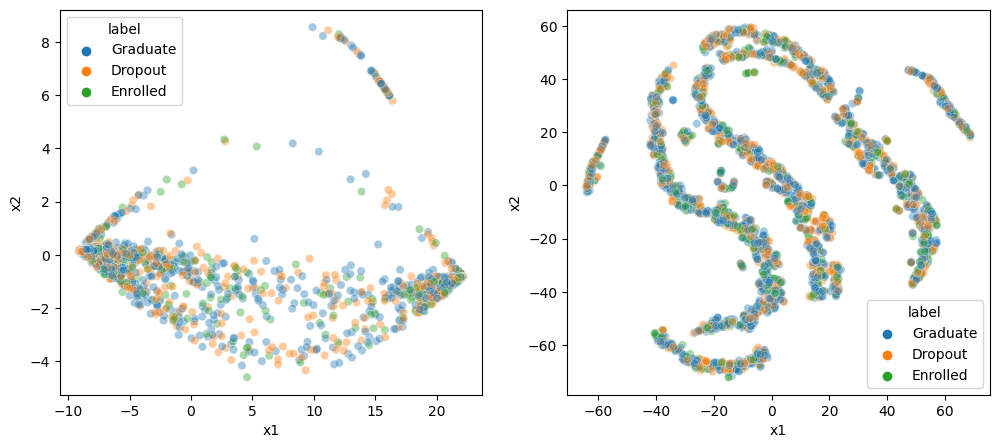

In [12]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sbn.scatterplot(data = train_pca_df, x = 'x1', y = 'x2', alpha = .4, hue = 'label', ax = ax[0])
sbn.scatterplot(data = train_tsne_df, x = 'x1', y = 'x2', alpha = .4, hue = 'label', ax = ax[1])

<AxesSubplot:xlabel='x1', ylabel='x2'>

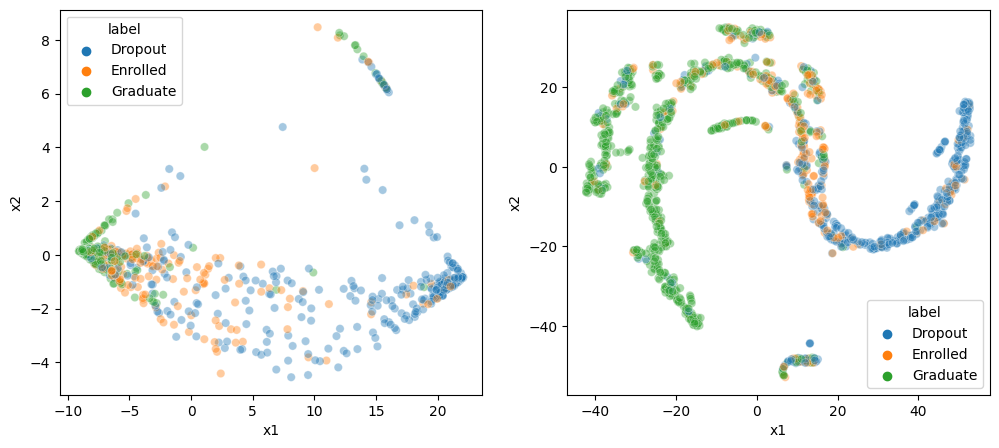

In [13]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
sbn.scatterplot(data = valid_pca_df, x = 'x1', y = 'x2', alpha = .4, hue = 'label', ax = ax[0])
sbn.scatterplot(data = valid_tsne_df, x = 'x1', y = 'x2', alpha = .4, hue = 'label', ax = ax[1])